In [1]:
from keras.datasets import mnist
from keras import layers
from keras import models
from tensorflow import keras
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
import math   
import os
import torchvision
import torch
import torch.nn as nn
import math
from torchvision import transforms
from PIL import Image, ImageDraw, ImageFilter
from numpy.core.fromnumeric import argmax
from facenet_pytorch import MTCNN, extract_face
import cv2
from  matplotlib import pyplot as plt
from torch.autograd import Variable
from scipy.io import loadmat
from sklearn.metrics import confusion_matrix

In [2]:
path ={
    # download training data from drive
    "train" : '../data/train/AFW',
    "model1" : '../data/models/model1.h5',
    "model2" : '../data/models/resnet.h5',
    "model3" : '../data/models/cross-entropy.h5',
    "test" : '../data/images/test_3.png',
    "test_group": '../data/images/group_3.png'
}

In [3]:
idx_tensor = [idx for idx in range(66)]
idx_tensor = tf.Variable(np.array(idx_tensor, dtype=np.float32))

In [4]:
alpha = 0.1
def loss_function(y_true, y_pred):
  real_true = y_true[:,0]
  bin_true = y_true[:,1]
  cat_f = tf.keras.losses.CategoricalCrossentropy(
  from_logits=True)
  bin_one_hot = tf.keras.utils.to_categorical(bin_true.numpy(),66)
  cls_loss = cat_f(bin_one_hot, y_pred)
  # # MSE loss
  pred_cont = tf.reduce_sum(tf.nn.softmax(y_pred) * idx_tensor, 1) * 3 - 99
  mse_loss = tf.losses.mean_squared_error(real_true, pred_cont)
  # # Total loss
  total_loss = cls_loss + alpha * mse_loss
  return total_loss

In [5]:
loaded_model = model = keras.models.load_model(path['model1'],custom_objects={"loss_func": loss_function})

In [7]:
from math import cos, sin
def draw_axis(img, yaw, pitch, roll, tdx=None, tdy=None, size = 100):

    pitch = pitch * np.pi / 180
    yaw = -(yaw * np.pi / 180)
    roll = roll * np.pi / 180

    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy
    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)
    return img

In [20]:
def test_model(model,img):
    mtcnn = MTCNN(keep_all=True, post_process=False,min_face_size = 10)
    boxes, probs, points = mtcnn.detect(img, landmarks=True)
    for i, box in enumerate(boxes):
        crop_img = extract_face(img, box, margin=50)
        crop_img = np.transpose(crop_img,(1,2,0))
        crop_img = crop_img.numpy()
        crop_img = np.array(Image.fromarray(np.uint8(crop_img)))
        crop_img = cv2.resize(crop_img,(240,240))
        val =model.predict(np.array([crop_img]))
        predictions = np.asarray(val)
        pred_cont_yaw = tf.reduce_sum(tf.nn.softmax(predictions[0,:,:]) * idx_tensor, 1) * 3 - 99
        pred_cont_pitch = tf.reduce_sum(tf.nn.softmax(predictions[1,:,:]) * idx_tensor, 1) * 3 - 99
        pred_cont_roll = tf.reduce_sum(tf.nn.softmax(predictions[2,:,:]) * idx_tensor, 1) * 3 - 99
        open_cv_image = np.array(Image.fromarray(np.uint8(img)))
        x = (box[0]+box[2])/2
        y = (box[1]+box[3])/2
        final_img = draw_axis(open_cv_image, pred_cont_yaw[0], pred_cont_pitch[0], pred_cont_roll[0],tdx = x,tdy=y)
        img = final_img
    cv2_imshow(img)
test_img = cv2.imread(path['test_group'])
test_model(loaded_model,test_img)

TypeError: can't multiply sequence by non-int of type 'float'

In [12]:
img = cv2.imread('../data/images/test_3.png')

TypeError: list indices must be integers or slices, not tuple

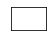

In [16]:
img = cv2.imread('../data/images/test_3.png')
img = cv2.resize(img,(240,240))
img = np.asarray([img])
feature_maps = loaded_model.predict(img)
# plot all 64 maps in an 8x8 squares
square = 8
ix = 1
for _ in range(square):
    for _ in range(square):
        # specify subplot and turn of axis
        ax = plt.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
        ix += 1
# show the figure
pyplot.show()